# Seminario Avanzado de Aprendizaje Automático
# _Inteligencia Artificial Explicable_
# Práctica 1

### Miguel A. Gutiérrez Naranjo
### _Versión del 3 de mayo de 2024_

Esta práctica está basada fundamentalmente en el Capítulo 3 del libro
**[Interpretable Machine Learning with Python](https://www.packtpub.com/product/interpretable-machine-learning-with-python/9781800203907)** de Serg Masís, publicado por Packt. En ella daremos un breve repaso por modelos de aprendizaje _intrínsecamente explicables_.

Cargamos las librerías que vamos a necesitar

In [2]:
import warnings
warnings.filterwarnings('ignore')

import requests
import zipfile
import io
import math
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics, linear_model, neighbors, tree, naive_bayes

En esta práctica tomaremos un dataset con información sobre vuelos. El objetivo es poder predecir con precisión los retrasos en los vuelos nacionales (domestic). Se espera
* Comprender qué factores tuvieron más impacto en los retrasos en las llegadas nacionales.
* Anticipar un retraso causado por la aerolínea en el aire con suficiente precisión para mitigar algunos de estos factores en el futuro.

Pero no todos los retrasos son iguales. La Asociación Internacional de Transporte Aéreo (IATA) tiene más de 80 códigos de retraso que van desde errores de reserva de ventas excesivas hasta deshielo de aeronaves. Algunas se pueden prevenir y otras son inevitables. Los ejecutivos de la aerolínea, por ahora, no están interesados en predecir los retrasos causados por eventos fuera de su control, como condiciones climáticas extremas, eventos de seguridad y problemas de control del tráfico aéreo.

Tampoco les interesan los retrasos causados ​​por llegadas tardías de vuelos anteriores utilizando el mismo avión porque ésta no era la causa principal.

Supongamos que hemos decidido abordar el problema como un problema de regresión (para predecir los minutos de retraso) y clasificación (para predecir si el retraso será de más de 15 minutos o no).

Descargamos el fichero.

In [3]:
# URL del archivo zip en GitHub
url = 'https://github.com/PacktPublishing/Interpretable-Machine-Learning-with-Python/raw/master/datasets/aa-domestic-delays-2018.csv.zip'

response = requests.get(url)
zip_file = zipfile.ZipFile(io.BytesIO(response.content))
with zip_file.open('aa-domestic-delays-2018.csv') as file:
        import pandas as pd
        aad18_df = pd.read_csv(file)

Vemos qué aspecto tiene el dataset que hemos descargado. Comprobamos qur tiene casi 900000 ejemplos y 23 atributos de cada ejemplo, de los cuales hay 17 con valores numéricos (punto flotante), 3 con valores enteros y 3 con valores categóricos. Además, no hay valores NULL.

In [ ]:
aad18_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 899527 entries, 0 to 899526
Data columns (total 23 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   FL_NUM                899527 non-null  int64  
 1   ORIGIN                899527 non-null  object 
 2   DEST                  899527 non-null  object 
 3   PLANNED_DEP_DATETIME  899527 non-null  object 
 4   CRS_DEP_TIME          899527 non-null  int64  
 5   DEP_TIME              899527 non-null  float64
 6   DEP_DELAY             899527 non-null  float64
 7   DEP_AFPH              899527 non-null  float64
 8   DEP_RFPH              899527 non-null  float64
 9   TAXI_OUT              899527 non-null  float64
 10  WHEELS_OFF            899527 non-null  float64
 11  CRS_ELAPSED_TIME      899527 non-null  float64
 12  PCT_ELAPSED_TIME      899527 non-null  float64
 13  DISTANCE              899527 non-null  float64
 14  CRS_ARR_TIME          899527 non-null  int64  
 15  

La interpretación de los atributos es la siguiente:

* FL_NUM : Número de vuelo
* ORIGIN : Código del aeropuerto de salida
* DEST : Código del aueropuerto de destino
* PLANNED_DEP_DATETIME : Fecha y hora programada para la salida
* CRS_DEP_TIME : Hora programada de despegue
* DEP_TIME : Hora real de despegue.
* DEP_AFPH : El número de vuelos reales por hora que ocurren durante el intervalo entre el despegue planificado y el real en el aeropuerto de origen (teniendo en cuenta 30 minutos de relleno). Este atributo indica el grado de ocupación del aeropuerto.
* DEP_RFPH : La frecuencia relativa de vuelos por hora es la relación de vuelos reales por hora sobre la media del número de vuelos por hora que ocurren en el aeropuerto de origen a esa hora del día, día de la semana y mes del año. Este atributo indica qué tan ocupado está el aeropuerto de origen durante el despegue.
* TAXI_OUT : Tiempo trascurrido entre la salida y la recogida de ruedas.
* WHEELS_OFF : Momento en el que las ruedas dejan de tocar el suelo.
* CRS_ELAPSED_TIME : Duración planificada del vuelo.
* PCT_ELAPSED_TIME : La relación entre el tiempo de vuelo real y el tiempo de vuelo planificado.
* DISTANCE : Distancia entre los aeropuertos de salida y de llegada.
* CRS_ARR_TIME : Hora de llegada planificada
* ARR_AFPH : El número de vuelos reales por hora que ocurren durante el intervalo entre la hora de llegada prevista y real al aeropuerto de destino. Este atributo indica qué tan ocupado estaba el aeropuerto de destino durante el aterrizaje.
* ARR_RFPH : Relación de vuelos reales por hora durante el número medio de vuelos por hora que ocurren en el aeropuerto de destino a esa hora del día, día de la semana y mes del año. Este atributo indica qué tan ocupado está el aeropuerto de destino durante el aterrizaje.
* DEP_DELAY : Retraso total en la salida en minutos
* ARR_DELAY : Retraso total a la llegada en minutos. Se subdivide en los siguientes atributos:
* a. CARRIER_DELAY: Retraso debido a circunstancias controlables por la aerolínes (limpieza del avión, carga del equipaje, etc).
* b. WEATHER_DELAY: Retraso debido a las condiciones meteorológicas.
* c. NAS_DELAY: Retraso debido al control aéreo (operaciones aeroportuarias, tráfico denso, ...)
* d. SECURITY_DELAY: Retraso debido a los controles de seguridad
* e. LATE_AIRCRAFT_DELAY: Retraso debido a que el vuelo previo del mismo avion llegó con retraso.




Trabajar con todo el dataset es muy costoso computacionalmente. Nos quedamos sólo que las primeras instancias a modo ilustrativo.

In [ ]:
NUM_INSTANCIAS = 10000
aad18_df = aad18_df.head(NUM_INSTANCIAS)

Antes de aplicar métodos de Aprendizaje Automático, necesitamos preprocesar los datos. En primer lugar, PLANNED_DEP_DATETIME debe tener formato temporal para poder procesarlo. Nos quedamos con el mes y el día de la semana y eliminamos el resto.

In [ ]:
# Cambiamos el tipo de dato de 'object' a 'datetime'
aad18_df['PLANNED_DEP_DATETIME'] = pd.to_datetime(aad18_df['PLANNED_DEP_DATETIME'])
# Creamos el atributo 'DEP_MONTH' con el mes planeado para el despegue
aad18_df['DEP_MONTH'] = aad18_df['PLANNED_DEP_DATETIME'].dt.month
# Creamos el atributo 'day_of_the_week' (DOW) con el día de la semana planeado para el despegue
aad18_df['DEP_DOW'] = aad18_df['PLANNED_DEP_DATETIME'].dt.dayofweek
# Eliminamos el atributo 'PLANNED_DEP_DATETIME'
aad18_df = aad18_df.drop(['PLANNED_DEP_DATETIME'], axis=1)

Vemos cómo queda el dataset

In [ ]:
aad18_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   FL_NUM               10000 non-null  int64  
 1   ORIGIN               10000 non-null  object 
 2   DEST                 10000 non-null  object 
 3   CRS_DEP_TIME         10000 non-null  int64  
 4   DEP_TIME             10000 non-null  float64
 5   DEP_DELAY            10000 non-null  float64
 6   DEP_AFPH             10000 non-null  float64
 7   DEP_RFPH             10000 non-null  float64
 8   TAXI_OUT             10000 non-null  float64
 9   WHEELS_OFF           10000 non-null  float64
 10  CRS_ELAPSED_TIME     10000 non-null  float64
 11  PCT_ELAPSED_TIME     10000 non-null  float64
 12  DISTANCE             10000 non-null  float64
 13  CRS_ARR_TIME         10000 non-null  int64  
 14  ARR_AFPH             10000 non-null  float64
 15  ARR_RFPH             10000 non-null  

Para poder realizar la predicción de retrasos, tenemos que saber si el aeropuerto de destino o llegada es un _aeropuerto central (hub airport)_ (o centro de transferencia y enlaces de vuelos). Declaramos en la lista 'hubs' qué aeropuertos son centrales.

In [ ]:
hubs = ['CLT', 'ORD', 'DFW', 'LAX', 'MIA', 'JFK', 'LGA', 'PHL', 'PHX', 'DCA']

Para poder hacer predicciones generales, en lugar de identificar cada aeropuerto concreto, sólo tendremos en cuenta si el aeropuerto correspondiente es central o no. Para ello, añadimos a cada instancia la información de si el aeropuerto de origen o destino es un aeropuerto central o no y eliminamos los datos relativos al código de los aeropuertos y el número de vuelo.

In [ ]:
# Booleano determinando si ORIGIN o DEST están en la lista 'hubs'
is_origin_hub = aad18_df['ORIGIN'].isin(hubs)
is_dest_hub = aad18_df['DEST'].isin(hubs)
# Creamos los nuevos atributos ORIGIN_HUB and DEST_HUB
aad18_df['ORIGIN_HUB'] = 0
aad18_df.loc[is_origin_hub, 'ORIGIN_HUB'] = 1
aad18_df['DEST_HUB'] = 0
aad18_df.loc[is_dest_hub, 'DEST_HUB'] = 1
# Eliminamos atributos
aad18_df = aad18_df.drop(['FL_NUM', 'ORIGIN', 'DEST'], axis=1)

Vemos cómo queda el dataset

In [ ]:
aad18_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   CRS_DEP_TIME         10000 non-null  int64  
 1   DEP_TIME             10000 non-null  float64
 2   DEP_DELAY            10000 non-null  float64
 3   DEP_AFPH             10000 non-null  float64
 4   DEP_RFPH             10000 non-null  float64
 5   TAXI_OUT             10000 non-null  float64
 6   WHEELS_OFF           10000 non-null  float64
 7   CRS_ELAPSED_TIME     10000 non-null  float64
 8   PCT_ELAPSED_TIME     10000 non-null  float64
 9   DISTANCE             10000 non-null  float64
 10  CRS_ARR_TIME         10000 non-null  int64  
 11  ARR_AFPH             10000 non-null  float64
 12  ARR_RFPH             10000 non-null  float64
 13  ARR_DELAY            10000 non-null  float64
 14  CARRIER_DELAY        10000 non-null  float64
 15  WEATHER_DELAY        10000 non-null  

Por último, vamos a normalizar el dataset, ya que hay magnitudes que no son comparables.

In [ ]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(aad18_df)
aad18_df = pd.DataFrame(aad18_df, columns=aad18_df.columns)

Finalmente, tenemos que decidir cuál va a ser el atributo que queremos predecir. Hay dos candidatos:
* ARR_DELAY : Retraso total a la llegada en minutos.
* CARRIER_DELAY: Retraso debido a circunstancias controlables por la aerolínes (limpieza del avión, carga del equipaje, etc).

Decidimos tomar 'CARRIER_DELAY' y suprimir el atributo 'ARR_DELAY' porque puede inducir a error.


In [ ]:
aad18_df = aad18_df.drop(['ARR_DELAY'], axis=1)

Creamos el dataset final tomando como atributo objetivo 'CARRIER_DELAY' y el reto para formar las instancias. Además, dividimos el dataset en entrenamiento y prueba y creamos la variable booleana 'y_class' (para train y test) que discrimina si el retraso ha sido mayor de 15 minutos o no.

In [ ]:
rand = 9
y = aad18_df['CARRIER_DELAY']
X = aad18_df.drop(['CARRIER_DELAY'], axis=1).copy()
X_train, X_test, y_train_reg, y_test_reg = train_test_split(X, y, test_size=0.15, random_state=rand)
y_train_class = y_train_reg.apply(lambda x: 1 if x > 15 else 0)
y_test_class = y_test_reg.apply(lambda x: 1 if x > 15 else 0)

Antes de aplicar los métodos de aprendizaje, podemos hacer un pequeño análisis exploratorio. Vamos a examinar si los atributos de entrada están correlacionados con el objetivo 'CARRIER_DELAY'. Para ello computamos el coeficiente de correlación de Pearson y los ordenamos según el valor absoluto del coeficiente.

In [ ]:
corr = aad18_df.corr()
abs(corr['CARRIER_DELAY']).sort_values(ascending=False)

CARRIER_DELAY          1.000000
DEP_DELAY              0.780010
DEP_DOW                0.068853
DEP_RFPH               0.065273
ARR_RFPH               0.061833
TAXI_OUT               0.052791
ARR_AFPH               0.052690
LATE_AIRCRAFT_DELAY    0.042859
NAS_DELAY              0.041421
DEST_HUB               0.034566
ORIGIN_HUB             0.021727
DEP_AFPH               0.014702
CRS_ELAPSED_TIME       0.009888
CRS_DEP_TIME           0.008761
PCT_ELAPSED_TIME       0.008619
DISTANCE               0.008351
WHEELS_OFF             0.006870
SECURITY_DELAY         0.006295
DEP_TIME               0.005406
WEATHER_DELAY          0.005231
CRS_ARR_TIME           0.001015
DEP_MONTH                   NaN
Name: CARRIER_DELAY, dtype: float64

A priori, no hay una clara correlación, pero debemos tener el cuenta que el coeficiente de correlación toma los atributos uno a uno.

Cada instancia tiene 21 atributos numéricos y obviamente, no podemos visualizar un punto en ${\mathbb R}^{21}$. Vamos a utlizar  TSNE para visualizar los datos en 3D. Más información sobre TSNE [aquí](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html).

In [ ]:
tsne_3d = TSNE(n_components=3, random_state=10, perplexity=25.0,init='random',learning_rate='auto')

# Limitamos el número de datos representados, para hacerlo menos costoso computacionalmente
NUM_REP = 100
X_3d = tsne_3d.fit_transform(X_train[:NUM_REP])

Representamos los puntos según su clasificación (si el retraso es mayor o no de 15 minutos).

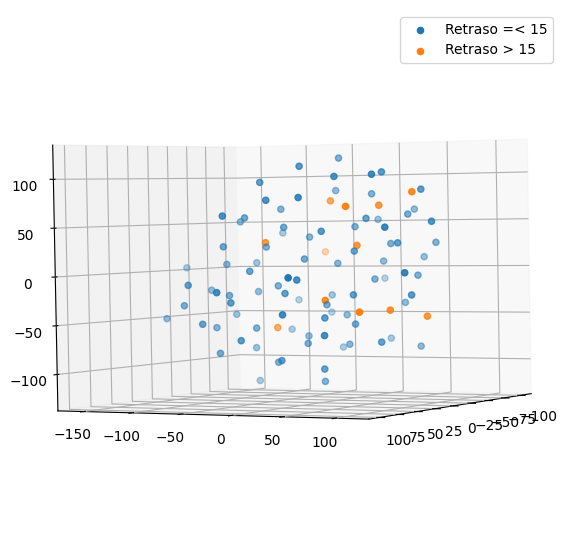

In [ ]:
fig = plt.figure(figsize=(12,7))
ax = fig.add_subplot(111, projection='3d')

for i, label in zip([0,1], ['Retraso =< 15','Retraso > 15']):
    ax.scatter(X_3d[:NUM_REP][y_train_class[:NUM_REP] == i, 0],
               X_3d[:NUM_REP][y_train_class[:NUM_REP] == i, 1],
               X_3d[:NUM_REP][y_train_class[:NUM_REP] == i, 2],label=label)

ax.azim = 30
ax.roll = 1
ax.elev = 1.5

plt.legend()
plt.show()

Podemos también obtener las tres componentes principales con PCA y representarlas en ${\mathbb R}^3$.

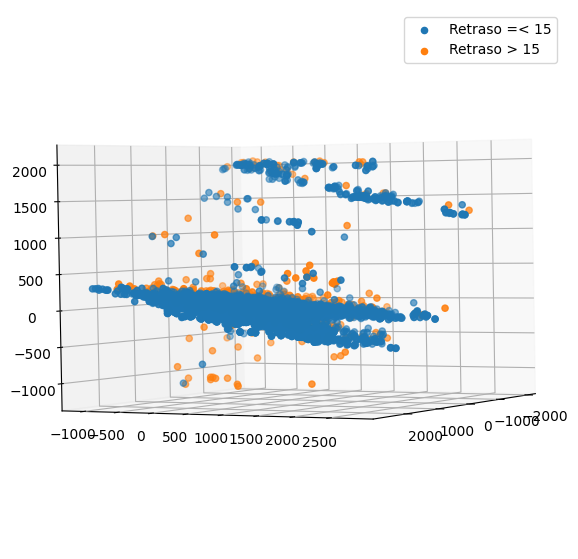

In [ ]:
pca = PCA(n_components=3)
PCA_X_train = pca.fit_transform(X_train)

fig = plt.figure(figsize=(12,7))
ax = fig.add_subplot(111, projection='3d')

for i, label in zip([0,1], ['Retraso =< 15','Retraso > 15']):
    ax.scatter(PCA_X_train[y_train_class == i, 0],
               PCA_X_train[y_train_class == i, 1],
               PCA_X_train[y_train_class == i, 2],label=label)

ax.azim = 30
ax.roll = 1
ax.elev = 1.5

plt.legend()
plt.show()



## Métodos _intrínsecamente interpretables_

Vamos a aplicar algunos métodos _intrínsecamente interpretables_ a nuestro problema. Todos los métodos los tomamos de _scikit learn_. Empezamos aplicando algunos métodos se regresión.

In [ ]:
reg_models = {
        'linear':{'model': linear_model.LinearRegression()},
        'ridge':{'model':  linear_model.RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1]) },
        'linear_poly':{'model': make_pipeline(PolynomialFeatures(degree=2),          # Regresión polinómica
                              linear_model.LinearRegression(fit_intercept=False)) },
        'lasso':{'model':  linear_model.Lasso()},
        'knn':{'model': neighbors.KNeighborsRegressor(n_neighbors=7)},               # Interpolación de los más cercanos
        'decision_tree':{'model': tree.DecisionTreeRegressor(max_depth=7, random_state=rand)},
    }

Entrenamos estos modelos con nuestro conjunto de entrenamiento y comprobamos la validez del modelo entrenado. Para ellos tomaremos los valores RMSE (raíz del erro cuadrático medio) sobre el conjunto de entrenamiento y sobre el conjunto de test y la métrica R2 sobre el conjunto de test.

In [ ]:
for model_name in reg_models.keys():
    print('Analizando',model_name,'...')
    fitted_model = reg_models[model_name]['model'].fit(X_train, y_train_reg)
    y_train_pred = fitted_model.predict(X_train.values)
    y_test_pred = fitted_model.predict(X_test.values)
    reg_models[model_name]['fitted'] = fitted_model
    reg_models[model_name]['preds'] = y_test_pred
    reg_models[model_name]['RMSE_train'] = math.sqrt(metrics.mean_squared_error(y_train_reg, y_train_pred))
    reg_models[model_name]['RMSE_test'] = math.sqrt(metrics.mean_squared_error(y_test_reg, y_test_pred))
    reg_models[model_name]['R2_test'] = metrics.r2_score(y_test_reg, y_test_pred)

Analizando linear ...
Analizando ridge ...
Analizando linear_poly ...
Analizando lasso ...
Analizando knn ...
Analizando decision_tree ...


Gráficamente

In [ ]:
reg_metrics = pd.DataFrame.from_dict(reg_models, 'index')[['RMSE_train', 'RMSE_test', 'R2_test']]
reg_metrics.sort_values(by='RMSE_test').style.\
    background_gradient(cmap='viridis', low=1, high=0.3, subset=['RMSE_train', 'RMSE_test']).\
    background_gradient(cmap='plasma', low=0.3, high=1, subset=['R2_test'])

,RMSE_train,RMSE_test,R2_test
ridge,7.987521,7.806027,0.886324
linear,7.987516,7.806157,0.886320
linear_poly,6.214729,7.961205,0.881759
decision_tree,5.219939,8.073872,0.878389
lasso,8.548548,8.136434,0.876497
knn,26.571607,19.647135,0.279874


Vemos que el menor RMSE sobre el conjunto de test se obtiene con la regresión lineal con regularización Ridge y el mayor valor para R2 también se obtiene para Ridge (en R2 un valor cercano a 1 significa que el modelo explica toda la variabilidad de la variable dependiente utilizando las variables independientes).

Veamos qué ocurre con los métodos de clasificación

In [ ]:
mi_n_neighbors = 3
class_models = {
        'reg_log':{'model': linear_model.LogisticRegression(class_weight='balanced')},
        # El clasificador Ridge transforma los valores objetivo en (-1,1)
        # y trata el problema de clasificación como si fuera regresión
        'ridge':{'model': linear_model.RidgeClassifierCV(cv=5, alphas=[1e-3, 1e-2, 1e-1, 1],\
                                                         class_weight='balanced')},
        'decision_tree':{'model': tree.DecisionTreeClassifier(max_depth=7, random_state=rand)},
        'knn':{'model': neighbors.KNeighborsClassifier(n_neighbors=mi_n_neighbors)},
        'naive_bayes':{'model': naive_bayes.GaussianNB()}}

Fíjate que en algunos de estos modelos estamos balanceando el peso que le damos a las clases _(class_weight='balanced' )_. Esto es crucial ya que, en general, el problema del retraso suele estar muy desbalanceado (el número de retrasos debe ser pequeño respecto al total). Podemos calcular la proporción en el conjunto de entrenamiento:


In [ ]:
print(y_train_class[y_train_class==1].shape[0] / y_train_class.shape[0])

0.10905882352941176


Vemos que la proporción de vuelos retrasados con respecto al total es pequeña. Entrenamos estos modelos y vemos algunas métricas (puedes obtener más información en el enlace asociado): [Accuracy](https://en.wikipedia.org/wiki/Accuracy_and_precision), [Recall](https://en.wikipedia.org/wiki/Precision_and_recall), [ROC_AUC](https://www.evidentlyai.com/classification-metrics/explain-roc-curve), [F1](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html) y [MCC](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.matthews_corrcoef.html)

In [ ]:
for model_name in class_models.keys():
    print('Analizando',model_name,'...')
    fitted_model = class_models[model_name]['model'].fit(X_train, y_train_class)
    y_train_pred = fitted_model.predict(X_train.values)
    if model_name == 'ridge':
        y_test_pred = fitted_model.predict(X_test.values)
    else:
        y_test_prob = fitted_model.predict_proba(X_test.values)[:,1]
        y_test_pred = np.where(y_test_prob > 0.5, 1, 0)
    class_models[model_name]['fitted'] = fitted_model
    class_models[model_name]['probs'] = y_test_prob
    class_models[model_name]['preds'] = y_test_pred
    class_models[model_name]['Accuracy_train'] = metrics.accuracy_score(y_train_class, y_train_pred)
    class_models[model_name]['Accuracy_test'] = metrics.accuracy_score(y_test_class, y_test_pred)
    class_models[model_name]['Recall_train'] = metrics.recall_score(y_train_class, y_train_pred)
    class_models[model_name]['Recall_test'] = metrics.recall_score(y_test_class, y_test_pred)
    if model_name != 'ridge':
        class_models[model_name]['ROC_AUC_test'] = metrics.roc_auc_score(y_test_class, y_test_prob)
    else:
        class_models[model_name]['ROC_AUC_test'] = 0
    class_models[model_name]['F1_test'] = metrics.f1_score(y_test_class, y_test_pred)
    class_models[model_name]['MCC_test'] = metrics.matthews_corrcoef(y_test_class, y_test_pred)

Analizando reg_log ...
Analizando ridge ...
Analizando decision_tree ...
Analizando knn ...
Analizando naive_bayes ...


Gráficamente

In [ ]:
class_metrics = pd.DataFrame.from_dict(class_models, 'index')[['Accuracy_train', 'Accuracy_test',\
                                                               'Recall_train', 'Recall_test',\
                                                               'ROC_AUC_test', 'F1_test', 'MCC_test']]
class_metrics.sort_values(by='ROC_AUC_test', ascending=False).style.\
    background_gradient(cmap='plasma', low=0.3, high=1, subset=['Accuracy_train', 'Accuracy_test']).\
    background_gradient(cmap='viridis', low=1, high=0.3, subset=['Recall_train', 'Recall_test',\
                                                                 'ROC_AUC_test', 'F1_test', 'MCC_test'])

,Accuracy_train,Accuracy_test,Recall_train,Recall_test,ROC_AUC_test,F1_test,MCC_test
reg_log,0.937647,0.940000,0.948220,0.958621,0.991571,0.755435,0.744763
decision_tree,0.985647,0.972667,0.927724,0.868966,0.974401,0.860068,0.844979
knn,0.947882,0.910000,0.622438,0.379310,0.805026,0.448980,0.410007
naive_bayes,0.873059,0.880667,0.240561,0.289655,0.778674,0.319392,0.256371
ridge,0.850588,0.849333,0.749730,0.703448,0.000000,0.474419,0.428146


Vemos que dos distintos métodos mantienen valores elevados de rendimiento en el conjunto de test.

### Interpretación

¿Cómo interpretamos la salida de estos métodos desde el punto de vista de la _explicabilidad_?

#### Regresión Lineal
La regresión lineal nos permite encontrar los coeficientes de un hiperplano $$\hat{y}= \beta_0 + \beta_1x_1 + \dots + \beta_nx_n$$ que mejor aproxima la nube de puntos y considera el valor del hiperplano como una _predicción_. En este caso los valores obtenidos son

In [ ]:
coefs_lm = reg_models['linear']['fitted'].coef_
intercept_lm = reg_models['linear']['fitted'].intercept_
print('coefficients:\t%s' % coefs_lm)
print('intercept:\t%s' % intercept_lm)

coefficients:	[ 3.25101601e-03 -3.14938731e-03  9.45080632e-01 -2.09213323e-02
 -2.07825254e-01  6.66175550e-02 -1.67291389e-03 -4.56255600e-02
  4.26842254e+01  4.46643033e-03 -2.03820580e-04  1.62235822e-03
 -1.46289173e-01 -9.81646071e-01 -3.87328919e-01 -9.34314725e-01
 -9.73563288e-01  6.57252031e-14  2.79924289e-01 -1.50372963e+00
 -1.54740634e+00]
intercept:	-34.52638592597752


Vistos a modo de ecuación, tenemos

In [ ]:
print('ŷ = %0.2f + %0.4fX₁ + %0.4fX₂ + %0.3fX₃ + ...' %\
      (intercept_lm, coefs_lm[0], coefs_lm[1], coefs_lm[2]))

ŷ = -34.53 + 0.0033X₁ + -0.0031X₂ + 0.945X₃ + ...


Pero es más práctico si asociamos cada coeficiente a un atributo

In [ ]:
coef_df = pd.DataFrame({'coef':coefs_lm}, index=(X_train.columns.values.tolist()))
print(coef_df)

                             coef
CRS_DEP_TIME         3.251016e-03
DEP_TIME            -3.149387e-03
DEP_DELAY            9.450806e-01
DEP_AFPH            -2.092133e-02
DEP_RFPH            -2.078253e-01
TAXI_OUT             6.661756e-02
WHEELS_OFF          -1.672914e-03
CRS_ELAPSED_TIME    -4.562556e-02
PCT_ELAPSED_TIME     4.268423e+01
DISTANCE             4.466430e-03
CRS_ARR_TIME        -2.038206e-04
ARR_AFPH             1.622358e-03
ARR_RFPH            -1.462892e-01
WEATHER_DELAY       -9.816461e-01
NAS_DELAY           -3.873289e-01
SECURITY_DELAY      -9.343147e-01
LATE_AIRCRAFT_DELAY -9.735633e-01
DEP_MONTH            6.572520e-14
DEP_DOW              2.799243e-01
ORIGIN_HUB          -1.503730e+00
DEST_HUB            -1.547406e+00


Podemos ordenar los coeficientes según su valor absoluto

In [ ]:
coef_df.abs().sort_values(by=['coef'],ascending=False)

,coef
PCT_ELAPSED_TIME,4.268423e+01
DEST_HUB,1.547406e+00
ORIGIN_HUB,1.503730e+00
WEATHER_DELAY,9.816461e-01
LATE_AIRCRAFT_DELAY,9.735633e-01
DEP_DELAY,9.450806e-01
SECURITY_DELAY,9.343147e-01
NAS_DELAY,3.873289e-01
DEP_DOW,2.799243e-01
DEP_RFPH,2.078253e-01


Podemos obtener la siguiente información:
* Los coeficientes de los atributos **continuos** nos permiten saber cómo cambia la predicción por cada unidad de cambio del atributo, si todos los demás atributos permanecen iguales, **ceteris paribus**
* Los coeficientes de atributos **binarios** (como ORIGEN_HUB) nos permiten saber cómo afecta la ocurrencia o no de esa propiedad en la predicción.
* La **ordenada en el origen** (intercept) no es un atributo, pero puede interpretarse como el valor de la función si todos los atributos tuvierna valor cero.



Podemos representar estos coeficientes con un diagramas de barras horizontales

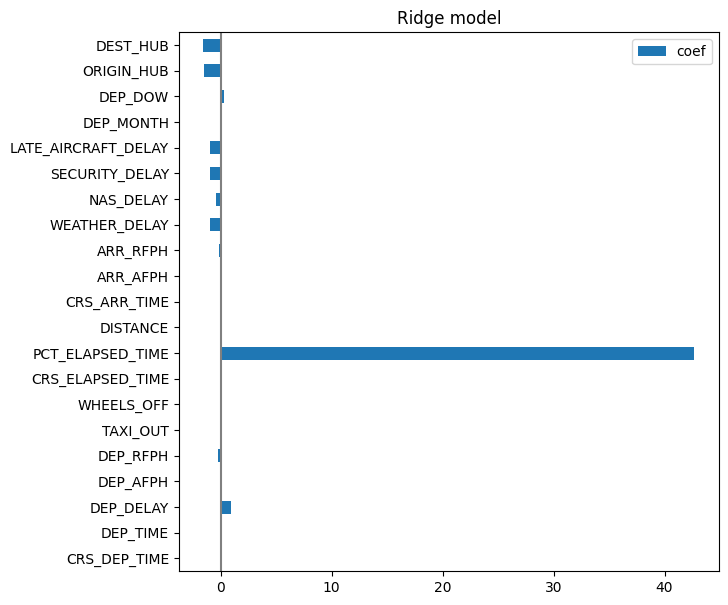

In [ ]:
coef_df.plot(kind="barh", figsize=(9, 7))
plt.title("Ridge model")
plt.axvline(x=0, color=".5")
plt.subplots_adjust(left=0.3)

#### Regresión Lasso y Ridge
La regresión Lasso y Ridge siguen siendo regresiones lineales, sólo que con regularización L1 y L2. Si comparamos los coeficientes, vemos que la regularización L1 (Lasso) lleva a algunos coeficientes a cero.


In [ ]:
coefs_ridge = reg_models['ridge']['fitted'].coef_
coefs_lasso = reg_models['lasso']['fitted'].coef_
coef_ridge_df = pd.DataFrame({'feature':X_train.columns.values.tolist(),\
                        'coef_linear': coefs_lm,\
                        'coef_ridge': coefs_ridge,\
                        'coef_lasso': coefs_lasso })
coef_ridge_df.style.\
    background_gradient(cmap='viridis_r', low=0.3, high=0.2, axis=1)


,feature,coef_linear,coef_ridge,coef_lasso
0,CRS_DEP_TIME,0.003251,0.003251,0.003157
1,DEP_TIME,-0.003149,-0.003150,-0.003664
2,DEP_DELAY,0.945081,0.945055,0.935106
3,DEP_AFPH,-0.020921,-0.020923,-0.020864
4,DEP_RFPH,-0.207825,-0.207823,-0.000000
5,TAXI_OUT,0.066618,0.066622,0.194005
6,WHEELS_OFF,-0.001673,-0.001670,-0.001277
7,CRS_ELAPSED_TIME,-0.045626,-0.045627,-0.073184
8,PCT_ELAPSED_TIME,42.684225,42.682985,0.000000
9,DISTANCE,0.004466,0.004480,0.007988


Podemos representar los coeficientes Lasso con barras horizontales

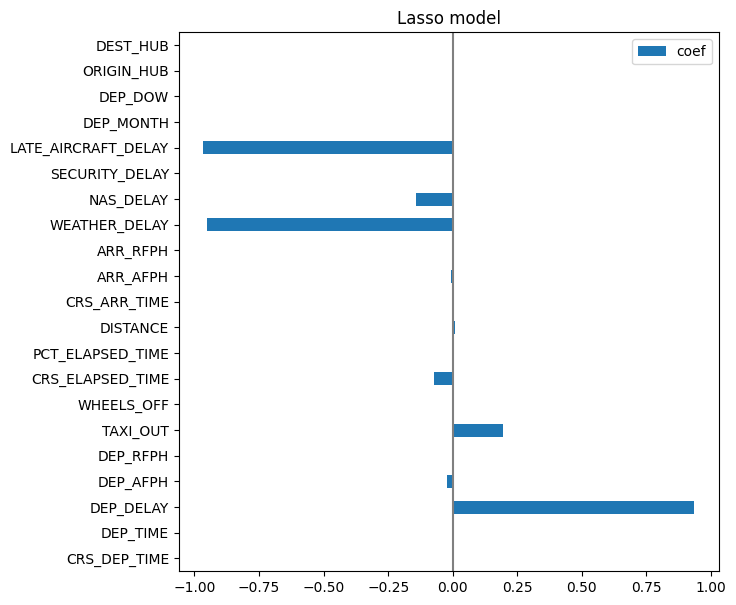

In [ ]:
coef_lasso_df = pd.DataFrame({'coef':coefs_lasso}, index=(X_train.columns.values.tolist()))
coef_lasso_df.plot(kind="barh", figsize=(9, 7))
plt.title("Lasso model")
plt.axvline(x=0, color=".5")
plt.subplots_adjust(left=0.3)


Obviamente, el resultado obtenido en Lasso y Ridge depende del coeficiente $\alpha$ que indica cómo de importante es el término de regularización. Podemos ver cómo evolucionan los coeficientes con varios valores del parámetro $\alpha$.

In [ ]:
num_alphas = 100
alphas = np.logspace(0, 13, num_alphas)
alphas_coefs = []
for alpha in alphas:
    ridge = linear_model.Ridge(alpha=alpha).fit(X_train, y_train_reg)
    alphas_coefs.append(np.concatenate((ridge.coef_[:8],ridge.coef_[9:])))
    # Si quieres dibujar las líneas de todos los atributos
    # alphas_coefs.append(ridge.coef_)


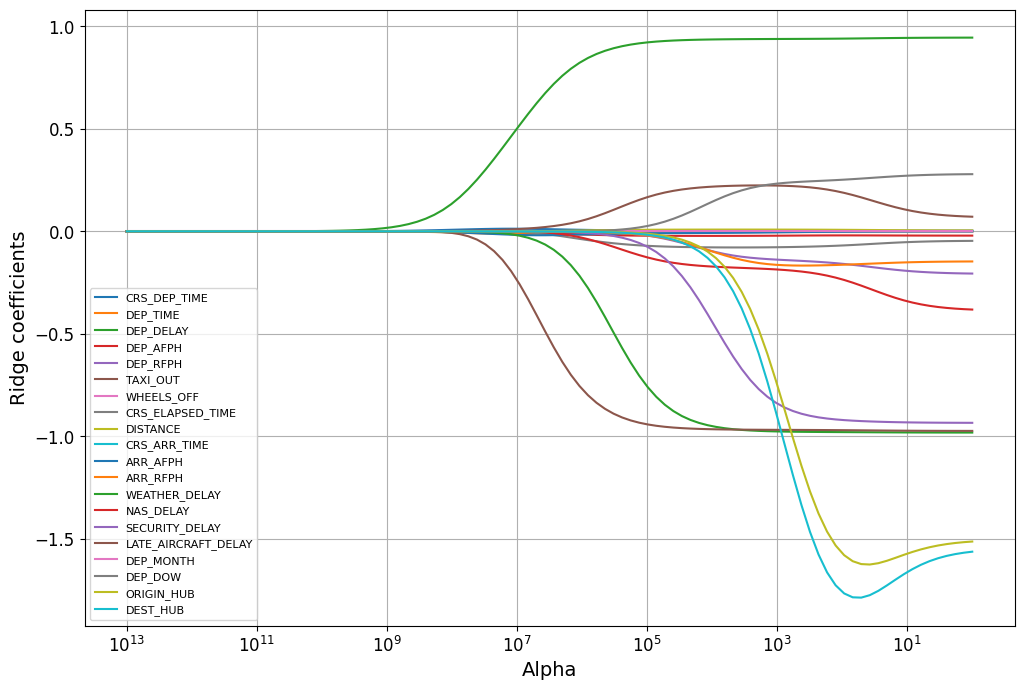

In [ ]:
plt.figure(figsize = (12,8))
plt.gca().invert_xaxis()
plt.tick_params(axis = 'both', which = 'major', labelsize = 12)
# Si quieres dibujar la evolución de todos los atributos
# mis_labels = X_train.columns.values.tolist()
mis_labels = np.concatenate((X_train.columns.values.tolist()[:8],X_train.columns.values.tolist()[9:]))
plt.plot(alphas, alphas_coefs,label = mis_labels)
plt.xscale("log")
plt.xlabel('Alpha', fontsize = 14)
plt.ylabel('Ridge coefficients', fontsize = 14)
plt.legend(loc='lower left',fontsize=8)
plt.grid()
plt.show()

Fíjate que cuando los valores de $\alpha$ son muy grandes, todos los coeficientes se acercan a cero, esto es, la diferencia entre el valor real y la predicción tiene muy poca importancia, lo importante es que los coeficientes sean pequeños. Obviamente, esto no es lo que queremos, por tanto, la regularización es útil si los hiperparámetros son los apropiados.

#### Regresión polinomial

En este caso, buscamos coeficientes que hagan mínimas las diferencias entre el valor real y el predictor, cuando el predictor es un polinomio, por ejemplo,

$$\hat{y} = f(x_1,x_2) =  \beta_0 + \beta_1x_1 + \beta_2x_2 + \beta_3x_1x_2 +\beta_4x_1^2 +\beta_5x_2^2$$

En nuestro caso, el número de coeficients obtenidos es



In [ ]:
print(reg_models['linear_poly']['fitted'].get_params()['linearregression'].coef_.shape[0])

253


Podemos ver los coeficientes del polinomio que tienen mayor valor absoluto, junto con los pares de atributos asociados a ese coeficiente.

In [ ]:
coefs_poly = reg_models['linear_poly']['fitted'].get_params()['linearregression'].coef_
poly = reg_models['linear_poly']['fitted'].named_steps['polynomialfeatures']
# Creamos los pares de atributos asociados a cada coeficiente
features_poly = poly.get_feature_names_out(X_train.columns.values.tolist())
coefs_poly_pairs_df = pd.DataFrame({'features_poly':features_poly,'coef': coefs_poly})

# Los ordenamos por valor absoluto y mstramos las primeras filas
NUM_FILAS = 15
coefs_poly_pairs_df.reindex(coefs_poly_pairs_df['coef'].abs().sort_values(ascending=False).index).head(NUM_FILAS)



,features_poly,coef
0,1,-4.915510e+06
243,DEP_MONTH^2,1.890585e+06
18,DEP_MONTH,1.890585e+06
251,ORIGIN_HUB DEST_HUB,-1.134352e+06
21,DEST_HUB,3.781168e+05
246,DEP_MONTH DEST_HUB,3.781168e+05
252,DEST_HUB^2,3.781168e+05
250,ORIGIN_HUB^2,3.781167e+05
245,DEP_MONTH ORIGIN_HUB,3.781167e+05
20,ORIGIN_HUB,3.781167e+05


#### Logistic Regression

En este caso, tenemos que la probabilidad de que la instancia se clasifique de manera positiva viene dada por la función
$$P(\hat{y}=1)= \frac{1}{1+ e^{-f(x_1,\dots,x_n)}}$$ con
$$f(x_1,\dots,x_n) = \beta_0 + \beta_1x_1 + \dots + \beta_nx_n$$
La interpretación es análoga a la regresión lineal. Aquellos coeficientes $\beta_i$ de mayor valor absoluto, mayor influencia tendrán sobre el valor de $f(x_1,\dots,x_n)$ y por tanto, sobre el valor de la sigmoide, **_ceteris paribus_**.

En nuestro caso

In [ ]:
coefs_log = class_models['reg_log']['fitted'].coef_
intercept_log = class_models['reg_log']['fitted'].intercept_
print('coefficients:\t%s' % coefs_log)
print('intercept:\t%s' % intercept_log)

coefficients:	[[-0.0003917  -0.00137045  0.21430067 -0.00441806 -0.00240379  0.02202699
   0.00117389 -0.02756402 -0.00078813  0.00269536 -0.00043188 -0.01873693
  -0.00152934 -0.02984032  0.01814109 -0.00146074 -0.21964734 -0.00150934
  -0.00533792  0.00163602 -0.0023128 ]]
intercept:	[-0.00150935]


Los representamos como barras horizontales

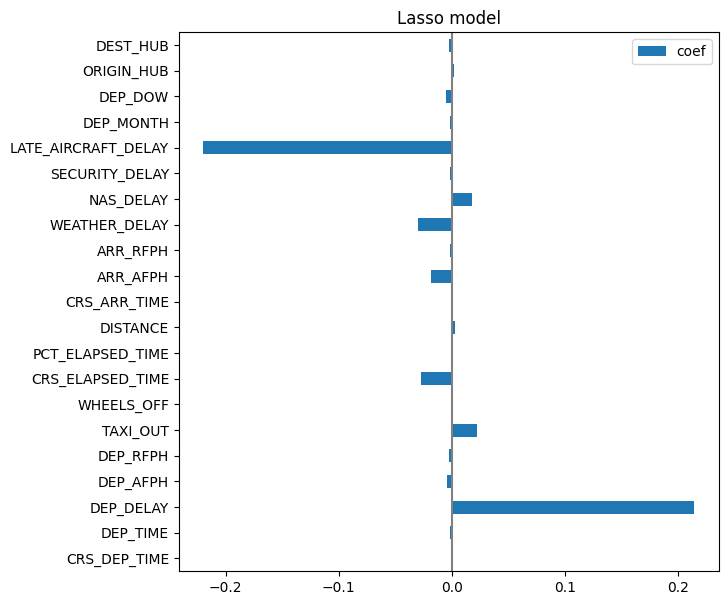

In [ ]:
coef_log_df = pd.DataFrame({'coef':coefs_log[0]}, index=(X_train.columns.values.tolist()))
coef_log_df.plot(kind="barh", figsize=(9, 7))
plt.title("Reg Log")
plt.axvline(x=0, color=".5")
plt.subplots_adjust(left=0.3)

#### Árboles de decisión

Los árboles de decisión son el prototipo de modelo interpretable, ya que cada nodo que nos lleva a un valor de clasificación es en sí mismo un criterio de decisión. Podemos digujar el árbol obtenido.

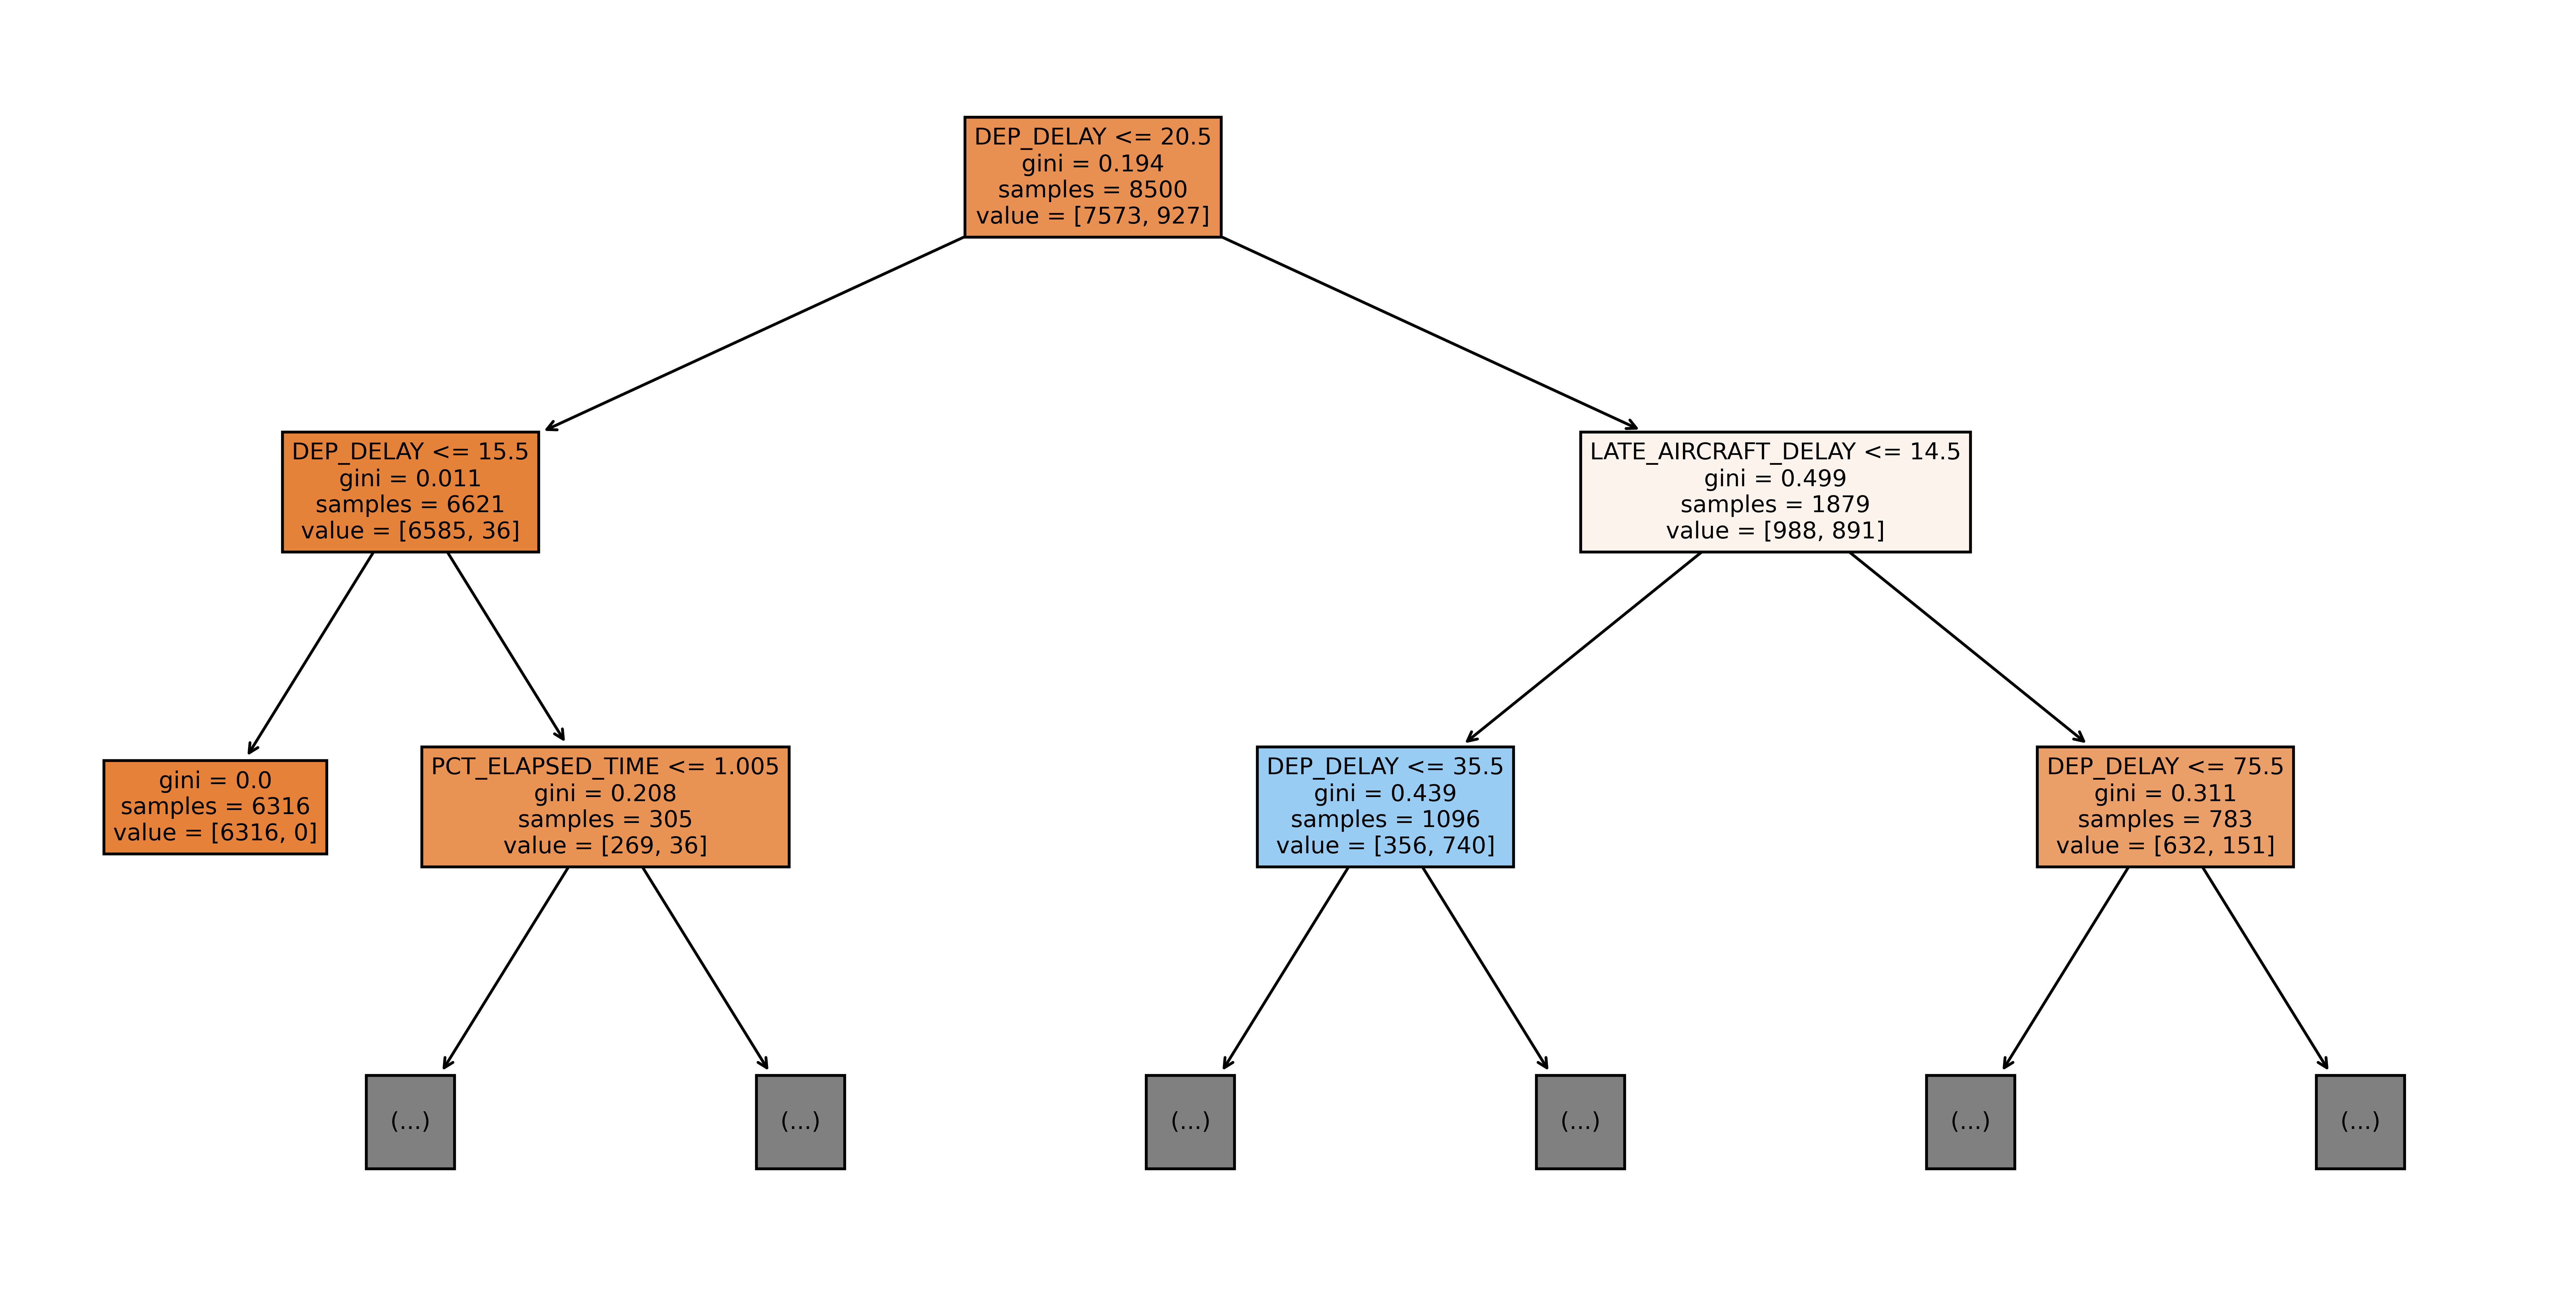

In [ ]:
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (16,8), dpi=600)
tree.plot_tree(class_models['decision_tree']['fitted'],\
               feature_names=X_train.columns.values.tolist(), filled = True, max_depth=2)
fig.show()

También podemos obtener el árbol en modo texto.

In [ ]:
text_tree = tree.export_text(class_models['decision_tree']['fitted'],\
               feature_names=X_train.columns.values.tolist())
print(text_tree)

|--- DEP_DELAY <= 20.50
|   |--- DEP_DELAY <= 15.50
|   |   |--- class: 0
|   |--- DEP_DELAY >  15.50
|   |   |--- PCT_ELAPSED_TIME <= 1.01
|   |   |   |--- TAXI_OUT <= 42.00
|   |   |   |   |--- DISTANCE <= 274.00
|   |   |   |   |   |--- DISTANCE <= 252.50
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- DISTANCE >  252.50
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |--- DISTANCE >  274.00
|   |   |   |   |   |--- ARR_RFPH <= 4.67
|   |   |   |   |   |   |--- PCT_ELAPSED_TIME <= 1.00
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |--- PCT_ELAPSED_TIME >  1.00
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- ARR_RFPH >  4.67
|   |   |   |   |   |   |--- CRS_ELAPSED_TIME <= 206.50
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |--- CRS_ELAPSED_TIME >  206.50
|   |   |   |   |   |   |   |--- class: 1
|   |   |   |--- TAXI_OUT >  42.00
|   |   |   |   |--- class: 1
|   |   |--- PCT_ELAPSED_TIME >  1.01
|   | 

_Scikit learn_ trae implementada la función **feature importance** para árboles de decisión. Su uso suele estar asociado al método _Random Forests_ pero se puede tomar también para un único árbol. La idea básica para medir la importancia de un atributo es saber si se ha usado (y cuánto) en la creación de un árbol.

In [ ]:
fi_tree = class_models['decision_tree']['fitted'].feature_importances_
fi_tree_df = pd.DataFrame({'feature importance':fi_tree}, index=(X_train.columns.values.tolist()))
print(fi_tree_df)


                     feature importance
CRS_DEP_TIME                   0.000000
DEP_TIME                       0.001554
DEP_DELAY                      0.605308
DEP_AFPH                       0.010316
DEP_RFPH                       0.000000
TAXI_OUT                       0.001319
WHEELS_OFF                     0.000191
CRS_ELAPSED_TIME               0.011682
PCT_ELAPSED_TIME               0.103357
DISTANCE                       0.005698
CRS_ARR_TIME                   0.002320
ARR_AFPH                       0.003023
ARR_RFPH                       0.004428
WEATHER_DELAY                  0.036128
NAS_DELAY                      0.007019
SECURITY_DELAY                 0.004251
LATE_AIRCRAFT_DELAY            0.202492
DEP_MONTH                      0.000000
DEP_DOW                        0.000000
ORIGIN_HUB                     0.000913
DEST_HUB                       0.000000


Lo vemos con un diagrama de barras horizontales

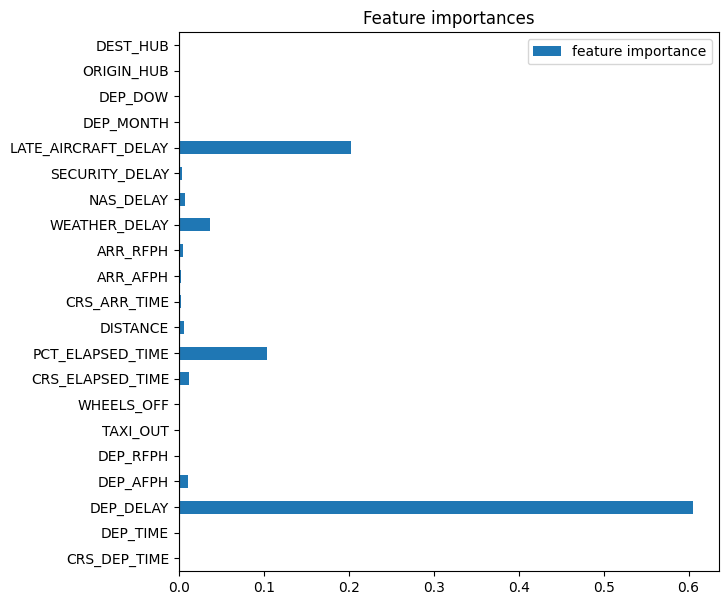

In [ ]:
fi_tree_df.plot(kind="barh", figsize=(9, 7))
plt.title("Feature importances")
plt.axvline(x=0, color=".5")
plt.subplots_adjust(left=0.3)

#### k vecinos más cercanos (kNN)
El método k-NN es un _método basado en instancias_ y no construye un model general de predicción. Únicamente admite explicación local para una instancia concreta y es, obviamente la clasificación mayoritaria, entee los $k$ vecinos más cercanos. Por ejemplo, tomemos un punto cualquiera del conjunto de test

In [ ]:
N_KNN = 73
X_test.iloc[N_KNN]

CRS_DEP_TIME           1045.000000
DEP_TIME               1049.000000
DEP_DELAY                 4.000000
DEP_AFPH                 47.812500
DEP_RFPH                  1.039402
TAXI_OUT                 24.000000
WHEELS_OFF             1113.000000
CRS_ELAPSED_TIME        235.000000
PCT_ELAPSED_TIME          0.957447
DISTANCE               1660.000000
CRS_ARR_TIME           1640.000000
ARR_AFPH                 85.555556
ARR_RFPH                  0.950617
WEATHER_DELAY             0.000000
NAS_DELAY                 0.000000
SECURITY_DELAY            0.000000
LATE_AIRCRAFT_DELAY       0.000000
DEP_MONTH                 1.000000
DEP_DOW                   0.000000
ORIGIN_HUB                0.000000
DEST_HUB                  1.000000
Name: 588, dtype: float64

Vemos su valor de predicción

In [ ]:
print(class_models['knn']['preds'][N_KNN])

0


Vemos sus valores más cercanos en el conjunto de entrenamiento

In [ ]:
nearest = class_models['knn']['fitted'].kneighbors(X_test.iloc[73].values.reshape(1,21), mi_n_neighbors)
print(nearest)

(array([[16.10482986, 21.69297454, 24.24489906]]), array([[230,  46, 357]]))


El primer vector obtenido corresponde a las distancias y el segundo a los índices de los $k$ puntos más cercanos en el conjunto de entrenamiento. Podemos ver la clasificación de esos puntos

In [ ]:
[y_train_class[i] for i in nearest[1]]



[230    0
 46     0
 357    0
 Name: CARRIER_DELAY, dtype: int64]

Vemos que el valor de clasificación corresponde con el valor mayoritario entre los $k$ puntos más cercanos.



#### Naïve Bayes Gaussiano

Recordamos el clasificador Naive Bayes Gaussiano devuelve la clase $c_{NB}$ asignada a la instancia $\langle a_1,\ldots,a_n\rangle$ calculada como
 $$c_{NB}=\mathop{argmax}_{c_j\in C} P(c_j)\prod_i P(a_i|c_j)$$
donde $P(c_j)$ es la frecuencia relativa de la clase $c_j$ en el conjunto de entrenamiento y
$$P(a_i \,|\, c_j) = \frac{1}{\sqrt{2\pi\sigma^2_{j,i}}} \exp\left(-\frac{(a_i - \mu_{j,i})^2}{2\sigma^2_{j,i}}\right)$$
donde $\mu_{j,i}$ es la media del atributo $i$ para la clase $c_j$ y $\sigma^2_{j,i}$ es la varianza del atributo $i$ para la clase $c_j$.

Para entender la salida de este clasificador y obtener su _explicabilidad_ en primer lugar podemos obtener las probabilidades _a prioi_ de cada una de las clases, esto es, $P(y=0)$ y $P(y=1)$.

Puedes obtener más información sobre este clasificador Naive Bayes Gaussiano con scikit learn [aquí](https://builtin.com/artificial-intelligence/gaussian-naive-bayes).

Podemos ver la frecuencia de las dos etiquetas de clasificación

In [ ]:
print(class_models['naive_bayes']['fitted'].class_prior_)

[0.89094118 0.10905882]


Como cabía esperar la frecuencia relativa de los vuelos con retraso es muy pequeña respecto a los vuelos sin retraso.

Para saber qué valores concretos hemos usado en la fórmula, Scikit Learn nos permite explorar esos valores.

Podemos obtener también los valores $\sigma^2_{j,i}$ es la varianza del atributo $i$ para cada una de las dos clases

In [ ]:
print(class_models['naive_bayes']['fitted'].var_)

[[2.66041706e+05 2.76716120e+05 1.41445159e+03 1.07811101e+03
  1.15382562e+00 8.67535682e+01 2.78569532e+05 6.52350913e+03
  8.94146451e-03 4.25948407e+05 2.89832301e+05 1.15796933e+03
  9.36184459e-01 4.83606764e+01 6.12001641e+01 7.04904302e-01
  1.14796441e+03 4.25937002e-04 1.45979287e+00 2.41222812e-01
  2.34506582e-01]
 [2.59069144e+05 2.98109627e+05 1.51925033e+04 1.00506993e+03
  4.24004006e+00 1.05499991e+02 3.07182737e+05 6.70575204e+03
  1.04213173e-02 4.25837713e+05 3.27916455e+05 1.00327628e+03
  3.01119885e+00 9.06945770e+00 8.40620461e+01 3.87973177e+00
  1.01748885e+03 4.25937002e-04 1.50554447e+00 1.82556413e-01
  2.50360479e-01]]


Por último, podemos obtener $\mu_{j,i}$ es la media del atributo $i$ para cada una de las clases.

In [ ]:
print(class_models['naive_bayes']['fitted'].theta_)

[[1.33103394e+03 1.33733712e+03 8.19411066e+00 5.05409291e+01
  1.18066933e+00 1.82737356e+01 1.35745425e+03 1.77084115e+02
  9.62889445e-01 1.06371359e+03 1.51071676e+03 5.14561221e+01
  1.20755996e+00 3.83335534e-01 1.83652449e+00 3.03710551e-02
  5.67727453e+00 1.00000000e+00 1.60623267e+00 5.95932920e-01
  6.26171927e-01]
 [1.39321359e+03 1.43513700e+03 8.83096009e+01 5.58554372e+01
  1.43864114e+00 1.97119741e+01 1.45204423e+03 1.76831715e+02
  9.71062852e-01 1.06109169e+03 1.53064941e+03 4.17316202e+01
  1.45939937e+00 3.06364617e-01 3.31823085e+00 6.47249191e-02
  1.10819849e+01 1.00000000e+00 1.28586839e+00 7.60517799e-01
  4.91909385e-01]]


En la próxima práctica veremos cómo podemos aplicar criterios de explicabilidad a modelos de predicción no intrínsecamente explicables sobre datos tabulados.